In [ ]:
!pip install networkx matplotlib

In [ ]:
# Install Camelot and dependencies (run in Google Colab or local Python environment)
!pip install camelot-py[cv]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 kB 3.7 MB/s eta 0:00:00


In [ ]:
!pip install camelot-py[cv] pdfplumber pandas

In [ ]:
!pip install camelot-py[cv] pandas

In [ ]:
import camelot
import pandas as pd

# Step 1: Upload the file
from google.colab import files
uploaded = files.upload()

# Step 2: Parse PDF with Camelot
tables = camelot.read_pdf("Enabiz-Tahlilleri.pdf", pages='all', flavor='stream')
print(f"Total tables extracted: {tables.n}")

# Step 3: Combine all tables
df_all = pd.concat([t.df for t in tables], ignore_index=True)

# Step 4: Drop rows that are clearly headers or metadata
df_all = df_all[~df_all.iloc[:, 0].str.contains("Adı Soyadı|Tarih|Referans|BİRİM", na=False)]

# Step 5: Rename columns for readability (adjust if structure varies)
df_all.columns = ["Tarih", "Tahlil", "Sonuç", "Birim", "Referans Aralığı"]

# Step 6: Drop rows where 'Tahlil' or 'Sonuç' are missing or invalid
df_cleaned = df_all.dropna(subset=["Tahlil", "Sonuç"])
df_cleaned = df_cleaned[df_cleaned["Sonuç"].str.strip().ne("")]

# Step 7: Preview cleaned DataFrame
pd.set_option("display.max_rows", None)
print(df_cleaned.head(20))

# Step 8: Save to CSV
df_cleaned.to_csv("cleaned_lab_results.csv", index=False)


/usr/local/lib/python3.11/dist-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


Saving Enabiz-Tahlilleri.pdf to Enabiz-Tahlilleri (2).pdf


Total tables extracted: 4
         Tarih              Tahlil        Sonuç  Birim Referans Aralığı
4   20.01.2025               LIPAZ           52    U/L             < 67
9            -             DANSİTE        1.025           1.005 - 1.027
10           -                  PH          6.0                 5.5 - 8
11           -             PROTEİN      NEGATİF  mg/dL          NEGATİF
12           -              GLUKOZ      NEGATİF  mg/dL          NEGATİF
13           -               KETON      NEGATİF  mg/dL          NEGATİF
14           -           BİLİRUBİN      NEGATİF  mg/dL          NEGATİF
15           -        ÜROBİLİNOJEN       NORMAL  mg/dL           NORMAL
16           -              NİTRİT      NEGATİF                 NEGATİF
17           -             LÖKOSİT  Pozitif (+)                 NEGATİF
21  20.01.2025      LDL KOLESTEROL          128  mg/dL        100 - 129
27  20.01.2025          Kolesterol          198  mg/dL            < 200
33  20.01.2025         TRIGLISERID    

In [ ]:
import re
import pdfplumber
# Step 2: Extract structured tables with Camelot
camelot_tables = camelot.read_pdf("Enabiz-Tahlilleri.pdf", pages='all', flavor='stream')
df_camelot = pd.concat([t.df for t in camelot_tables], ignore_index=True)

# Drop rows that are header-like
df_camelot = df_camelot[~df_camelot.iloc[:, 0].str.contains("Adı Soyadı|Tarih|Referans|BİRİM", na=False)]

# Standardize headers
df_camelot.columns = ["Tarih", "Tahlil", "Sonuç", "Birim", "Referans Aralığı"]
df_camelot = df_camelot.dropna(subset=["Tahlil", "Sonuç"])
df_camelot = df_camelot[df_camelot["Sonuç"].str.strip().ne("")]

# Step 3: Use pdfplumber to search for any additional test mentions (especially urinalysis rows)
missing_tests = []
with pdfplumber.open("Enabiz-Tahlilleri.pdf") as pdf:
    for page in pdf.pages:
        text = page.extract_text()
        matches = re.findall(r"[-•]?\s*(\w[\w\s%+()]+)\s+([0-9.,NAna\+\-]+)\s+(\w+/L|mg/dL|U/L|%|NORMAL|NEGATİF|POZİTİF|.+)", text)
        for match in matches:
            test, result, unit = [x.strip() for x in match]
            if test not in df_camelot["Tahlil"].values:
                missing_tests.append({"Tarih": "", "Tahlil": test, "Sonuç": result, "Birim": unit, "Referans Aralığı": ""})

# Step 4: Merge plumber-extracted rows (as fallback) into main DataFrame
df_fallback = pd.DataFrame(missing_tests)
df_combined = pd.concat([df_camelot, df_fallback], ignore_index=True)

# Step 5: Output cleaned data
df_combined.to_csv("enabiz_cleaned_combined.csv", index=False)
print(f"Final combined row count: {len(df_combined)}")
df_combined.head(20)

Final combined row count: 124


,Tarih,Tahlil,Sonuç,Birim,Referans Aralığı
0,20.01.2025,LIPAZ,52,U/L,< 67
1,-,DANSİTE,1.025,,1.005 - 1.027
2,-,PH,6.0,,5.5 - 8
3,-,PROTEİN,NEGATİF,mg/dL,NEGATİF
4,-,GLUKOZ,NEGATİF,mg/dL,NEGATİF
5,-,KETON,NEGATİF,mg/dL,NEGATİF
6,-,BİLİRUBİN,NEGATİF,mg/dL,NEGATİF
7,-,ÜROBİLİNOJEN,NORMAL,mg/dL,NORMAL
8,-,NİTRİT,NEGATİF,,NEGATİF
9,-,LÖKOSİT,Pozitif (+),,NEGATİF


In [ ]:
import re
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
# STEP 1: Simulated abstracts from PubMed or literature
# -------------------------------

abstracts = [
    "Vitamin C enhances the absorption of Iron.",
    "Calcium inhibits the absorption of Iron.",
    "Zinc and Copper compete for absorption in the gut.",
    "Vitamin D enhances Calcium uptake in the intestine.",
    "Magnesium inhibits Calcium absorption.",
    "Folic Acid works synergistically with Vitamin B12 to support red blood cell production."
]


In [ ]:
# -------------------------------
# STEP 2: Pattern-based relation extractor
# -------------------------------

def extract_relation(sentence):
    patterns = [
        (r"(\w+\s?\w*) enhances (?:the )?absorption of (\w+\s?\w*)", "enhances"),
        (r"(\w+\s?\w*) inhibits (?:the )?absorption of (\w+\s?\w*)", "inhibits"),
        (r"(\w+) and (\w+) compete for absorption", "competes"),
        (r"(\w+\s?\w*) works synergistically with (\w+\s?\w*)", "synergizes")
    ]
    for pattern, relation in patterns:
        match = re.search(pattern, sentence, re.IGNORECASE)
        if match:
            return (match.group(1).title(), match.group(2).title(), relation)
    return None

# Apply extraction to all abstracts
relations = [extract_relation(s) for s in abstracts]
relations = [r for r in relations if r]  # Remove None entries

In [ ]:
# -------------------------------
# STEP 3: Create a directed graph with NetworkX
# -------------------------------

G = nx.DiGraph()

# Simulated confidence scores (0.8–1.0)
import random
for source, target, relation in relations:
    G.add_edge(source, target, relation=relation, weight=round(random.uniform(0.8, 1.0), 2))

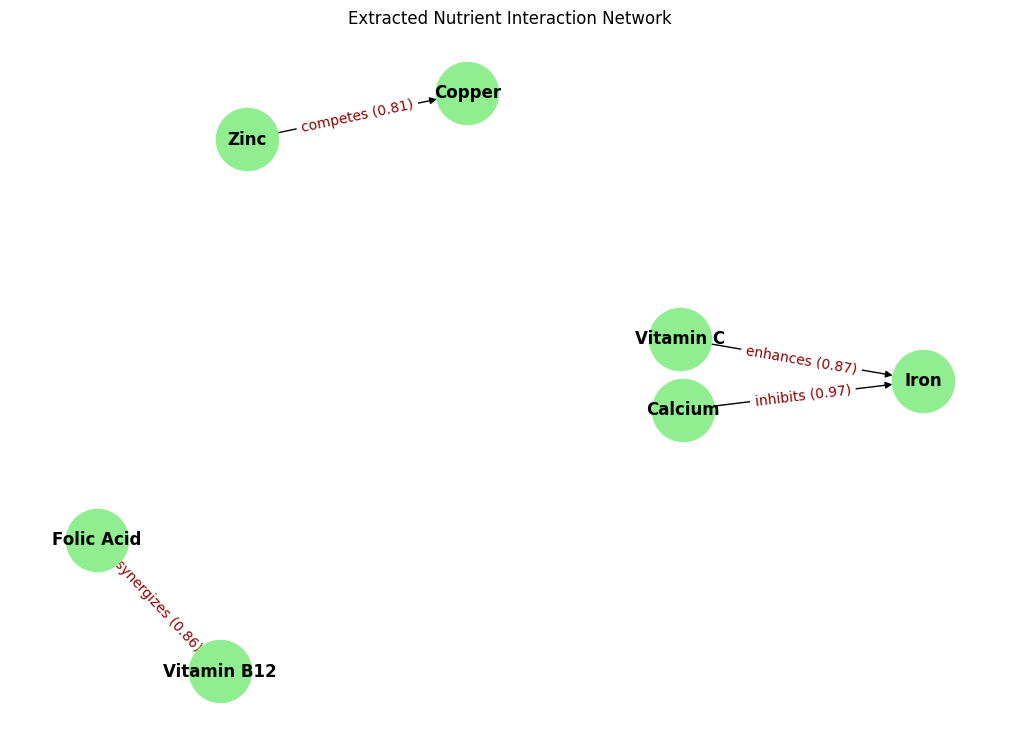

In [ ]:
# -------------------------------
# STEP 4: Visualize the graph
# -------------------------------

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)
edge_labels = {(u, v): f"{d['relation']} ({d['weight']})" for u, v, d in G.edges(data=True)}

nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightgreen", font_size=12, font_weight="bold", arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkred')

plt.title("Extracted Nutrient Interaction Network")
plt.axis("off")
plt.show()

In [ ]:
# -------------------------------
# STEP 5: Query example — What enhances Iron?
# -------------------------------

def find_enhancers(target):
    enhancers = []
    for u, v, data in G.edges(data=True):
        if v.lower() == target.lower() and data["relation"] in ["enhances", "synergizes"]:
            enhancers.append((u, data["weight"]))
    return enhancers

print("Nutrients that enhance Iron absorption:", find_enhancers("Iron"))

Nutrients that enhance Iron absorption: [('Vitamin C', 0.87)]


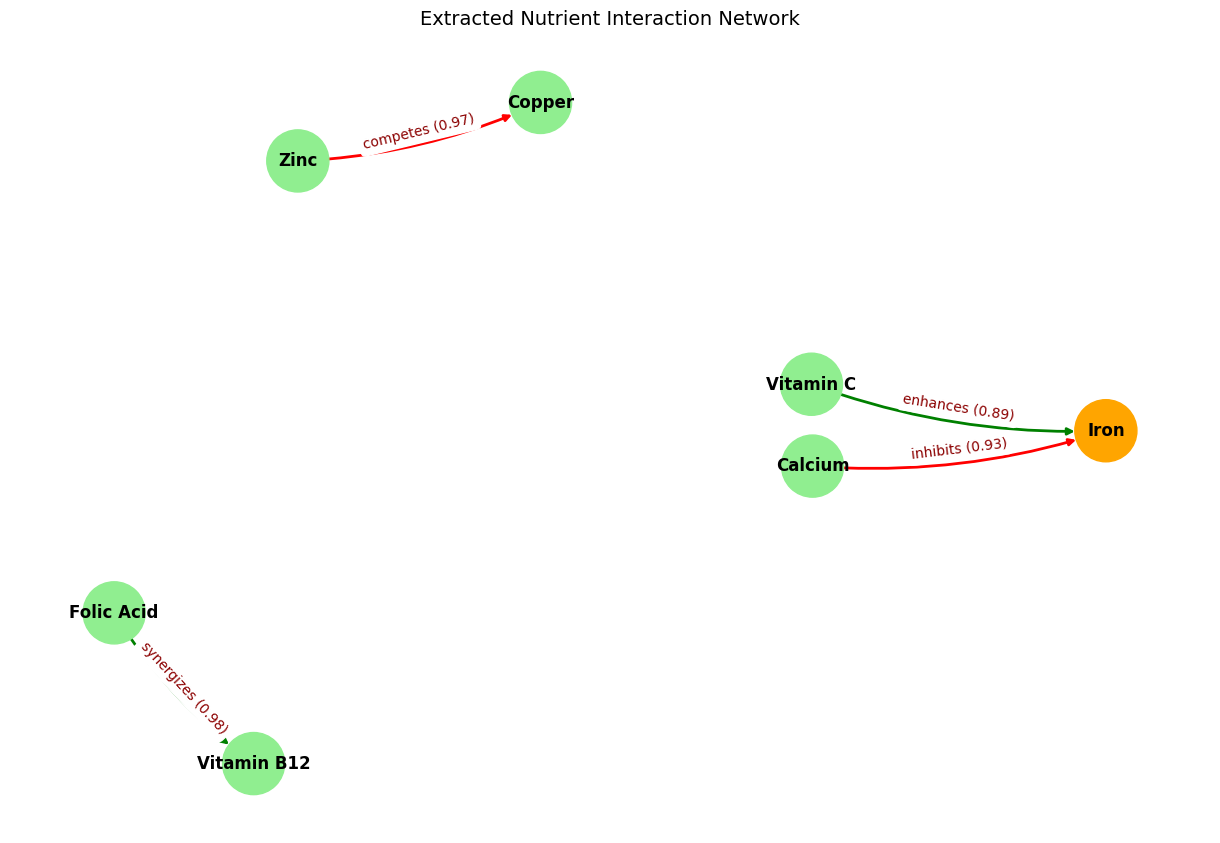

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import re
import random

# Step 1: Simulated literature sentences
abstracts = [
    "Vitamin C enhances the absorption of Iron.",
    "Calcium inhibits the absorption of Iron.",
    "Zinc and Copper compete for absorption in the gut.",
    "Vitamin D enhances Calcium uptake in the intestine.",
    "Magnesium inhibits Calcium absorption.",
    "Folic Acid works synergistically with Vitamin B12 to support red blood cell production."
]

# Step 2: Relation extractor
def extract_relation(sentence):
    patterns = [
        (r"(\w+\s?\w*) enhances (?:the )?absorption of (\w+\s?\w*)", "enhances"),
        (r"(\w+\s?\w*) inhibits (?:the )?absorption of (\w+\s?\w*)", "inhibits"),
        (r"(\w+) and (\w+) compete for absorption", "competes"),
        (r"(\w+\s?\w*) works synergistically with (\w+\s?\w*)", "synergizes")
    ]
    for pattern, relation in patterns:
        match = re.search(pattern, sentence, re.IGNORECASE)
        if match:
            return (match.group(1).title(), match.group(2).title(), relation)
    return None

# Step 3: Build relation list with confidence scores
relations = [extract_relation(s) for s in abstracts if extract_relation(s)]
G = nx.DiGraph()

for source, target, relation in relations:
    confidence = round(random.uniform(0.8, 1.0), 2)
    G.add_edge(source, target, relation=relation, weight=confidence)

# Step 4: Color-coding logic
edge_colors = []
edge_labels = {}
for u, v, data in G.edges(data=True):
    if data["relation"] in ["enhances", "synergizes"]:
        edge_colors.append("green")
    else:
        edge_colors.append("red")
    edge_labels[(u, v)] = f'{data["relation"]} ({data["weight"]})'

node_colors = []
for node in G.nodes():
    if node == "Iron":
        node_colors.append("orange")
    else:
        node_colors.append("lightgreen")

# Step 5: Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos, with_labels=True, node_size=2000, node_color=node_colors,
        font_size=12, font_weight="bold", arrows=True, edge_color=edge_colors,
        width=2, connectionstyle="arc3,rad=0.1")

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkred', font_size=10)

plt.title("Extracted Nutrient Interaction Network", fontsize=14)
plt.axis("off")
plt.show()
